# `CRO` fitting

This tutorial illustrates how to use the `pyCRO` to estimate RO parameters from the observation and climate model outputs

Contact:
 - Sen Zhao (zhaos@hawaii.edu)


In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import os
import sys
    
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../../"))
import pyCRO
from pyCRO import RO_fitting, RO_solver, RO_analytic_std, RO_analytic_solver, RO_BWJ, func_mon_std, par_load

## Fitting to the observation/reanalysis

### Load observation ENSO timeseries

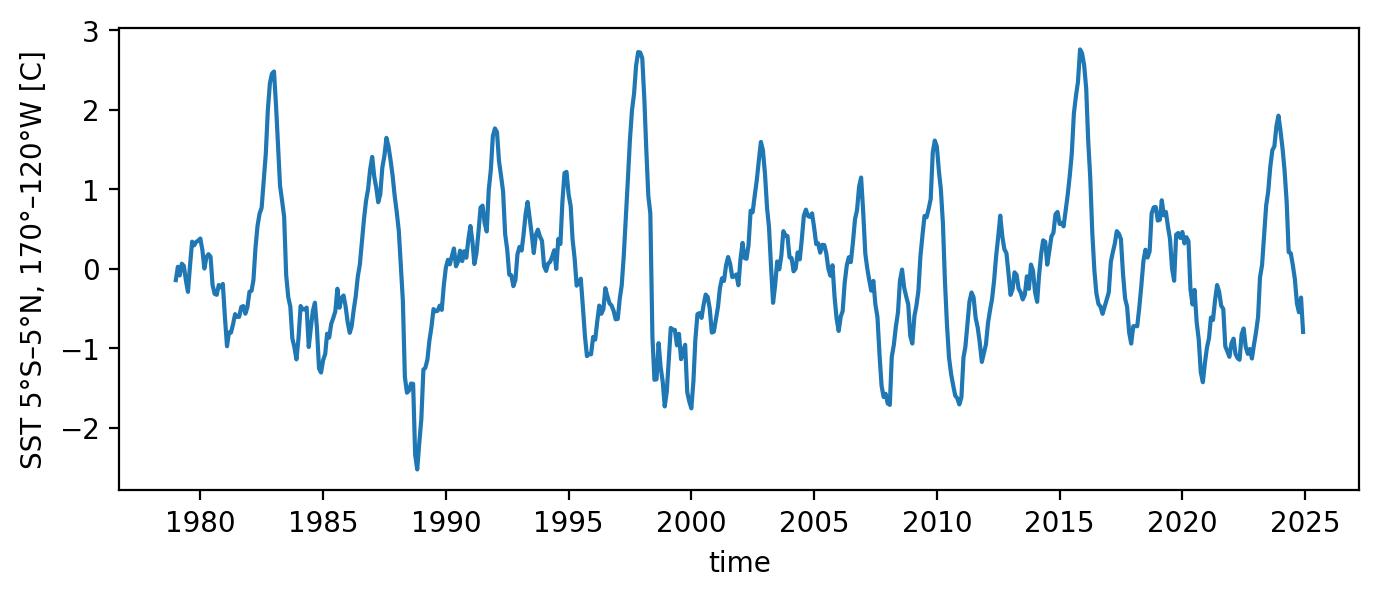

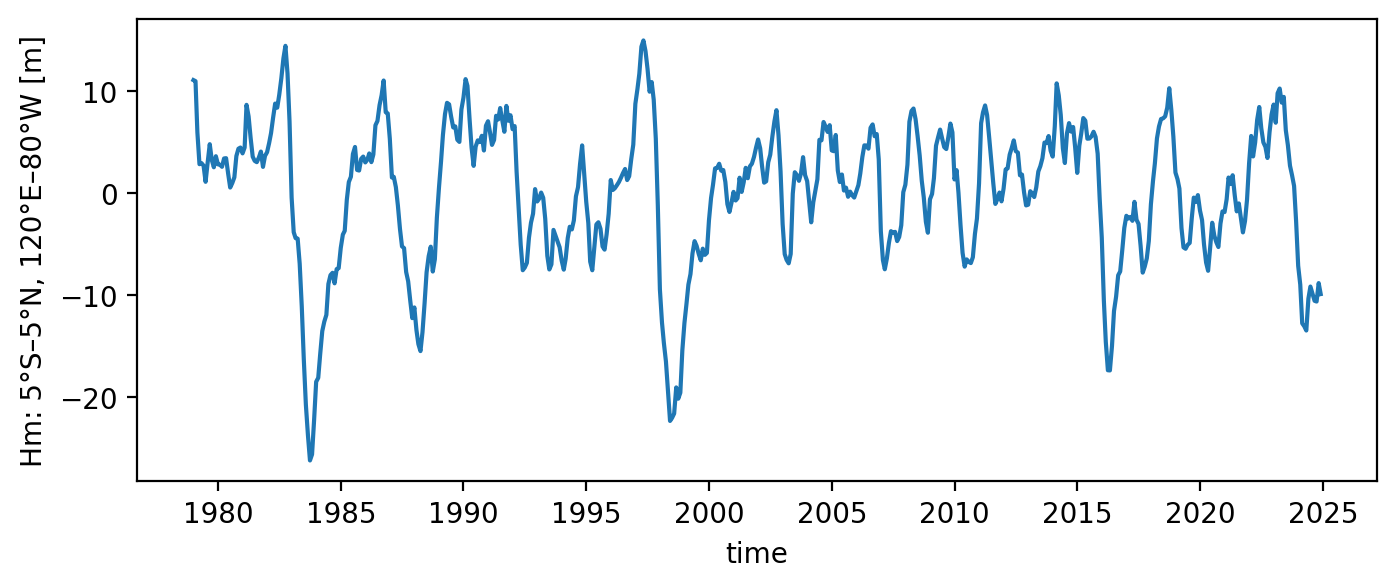

In [2]:
# load observations
file_name = os.path.join(os.getcwd(), "../../data", "XRO_indices_oras5.nc")
xr_ds = xr.open_dataset(file_name)
T_oras5 = xr_ds['Nino34'][:]  # Nino 3.4 since 1979-01-01
h_oras5 = xr_ds['WWV'][:]     # WWV since 1979-01-01
time_oras5 = xr_ds['time'][:] # Days since 1979-01-01

T_oras5.plot(figsize=(8, 3))
h_oras5.plot(figsize=(8, 3))

### Fit with type: linear RO with white addtive noise

In [11]:
# setting fitting options and print the fitted parameters
par_option_T = {"R": 1, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted_obs = RO_fitting(T_oras5, h_oras5, par_option_T, par_option_h, par_option_noise)
print(par_fitted_obs)

---------------------------------------------------------------------------------
Welcome to CRO Fitting! Your fitting setups:
---------------------------------------------------------------------------------
 - Data time step is not given, defaulting to: dt = 1.0 months.
 - Time series length: N = len(T)*dt = 552.0 months.
 - Prescribed terms: {'R': 1, 'F1': 1, 'b_T': 0, 'c_T': 0, 'd_T': 0}. 
                     {'F2': 1, 'epsilon': 1, 'b_h': 0}. 
   0 - Do not prescribe. 
   1 - Prescribe only the annual mean. 
   3 - Prescribe the annual mean and annual seasonality. 
   5 - Prescribe the annual mean, annual seasonality, and semi-annual seasonality.
 - Noise options: {'T': 'white', 'h': 'white', 'T_type': 'additive'}.
 - Fitting method for T and h main equations: None.
Referring to table_default_fitting_method.txt and using LR-F
---------------------------------------------------------------------------------
All steps are successfully completed!
------------------------------------

In [12]:
# setting fitting options and print the fitted parameters
par_option_T = {"R": 3, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted_obs2 = RO_fitting(T_oras5, h_oras5, par_option_T, par_option_h, par_option_noise)
print(par_fitted_obs2)

---------------------------------------------------------------------------------
Welcome to CRO Fitting! Your fitting setups:
---------------------------------------------------------------------------------
 - Data time step is not given, defaulting to: dt = 1.0 months.
 - Time series length: N = len(T)*dt = 552.0 months.
 - Prescribed terms: {'R': 3, 'F1': 1, 'b_T': 0, 'c_T': 0, 'd_T': 0}. 
                     {'F2': 1, 'epsilon': 1, 'b_h': 0}. 
   0 - Do not prescribe. 
   1 - Prescribe only the annual mean. 
   3 - Prescribe the annual mean and annual seasonality. 
   5 - Prescribe the annual mean, annual seasonality, and semi-annual seasonality.
 - Noise options: {'T': 'white', 'h': 'white', 'T_type': 'additive'}.
 - Fitting method for T and h main equations: None.
Referring to table_default_fitting_method.txt and using LR-F
---------------------------------------------------------------------------------
All steps are successfully completed!
------------------------------------

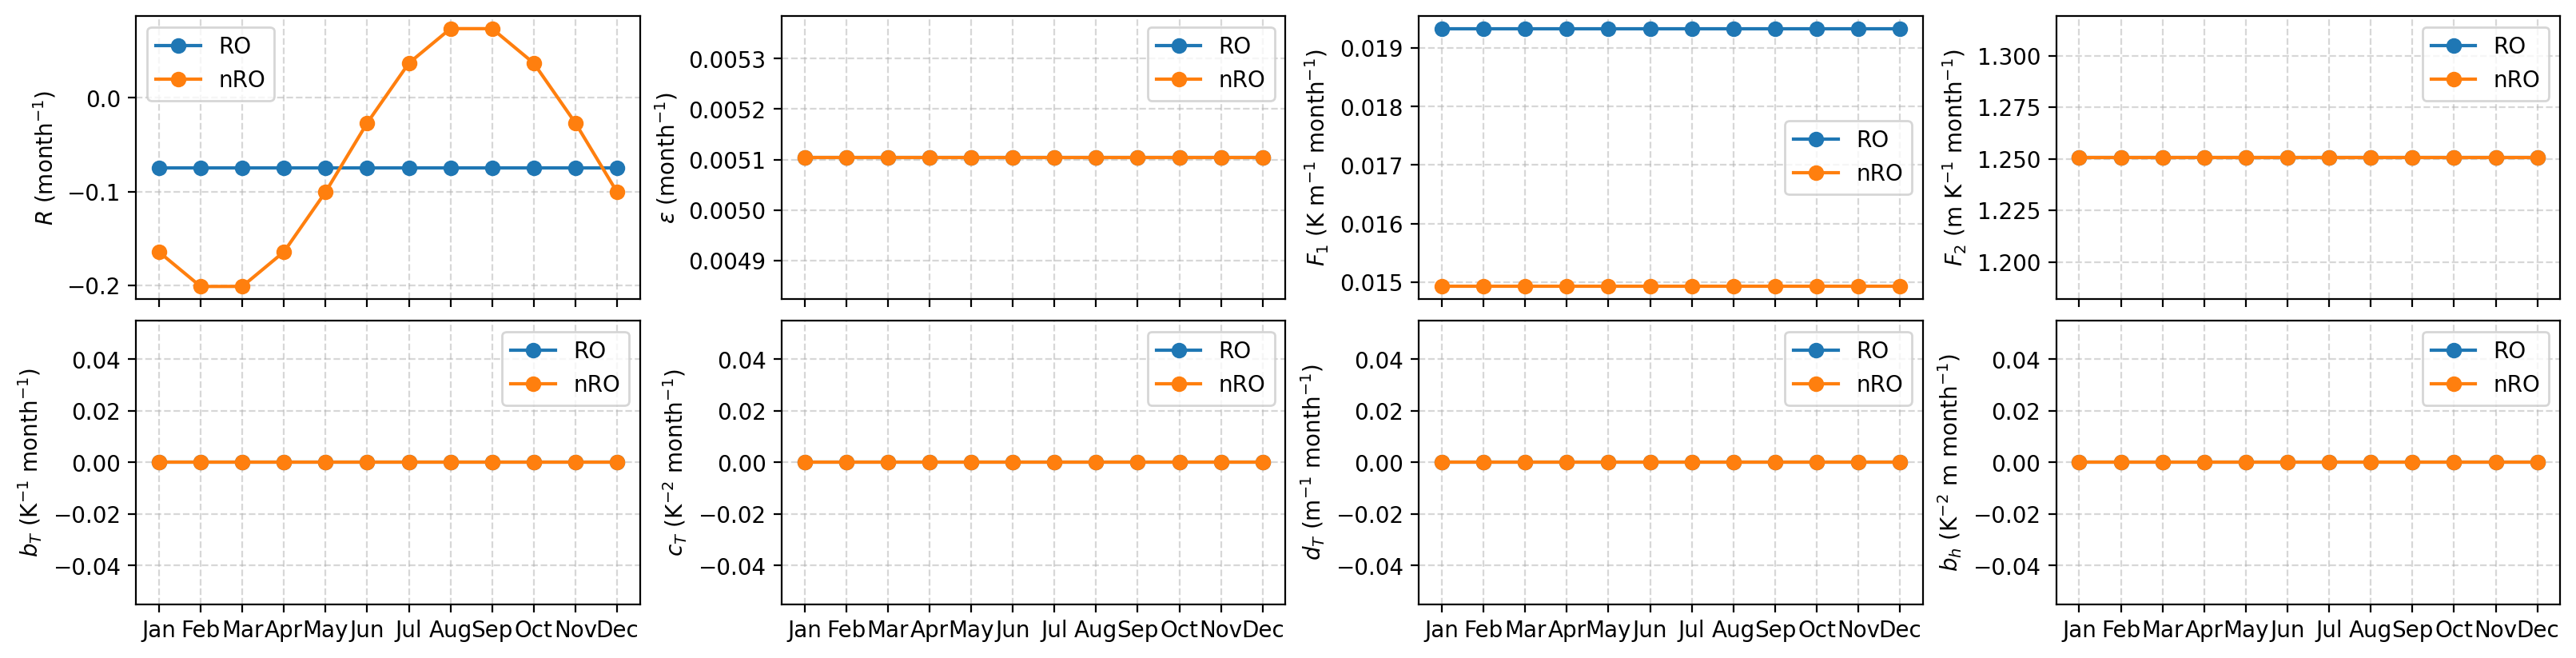

In [13]:
axes = pyCRO.plot_RO_par(par_fitted_obs, label='RO')
axes1 = pyCRO.plot_RO_par(par_fitted_obs2, label='nRO', ax=axes)
